In [ ]:
import os
import sys
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import combinations
import networkx as nx
import logging
logger = logging.getLogger()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
root_dir = '/content/gdrive/My Drive/'
base_dir = root_dir + 'knowledge engineering/assignments/assignment_1/'

Mounted at /content/gdrive


In [ ]:
class PrepareData:
    def __init__(self, dat, field_filter=None, filter_connections_flag=False,
                 filter_num=8):
        self.data = data
        self.field_filter = field_filter
        self.filter_connections_flag = filter_connections_flag
        self.filter_num = filter_num

    def filter_query(self):
        query = []
        for i in self.data['results']['bindings']:
            temp_query = {}
            for key, value in i.items():
                temp_query[key] = value.get('value')
            query.append(temp_query)
        return query

    def to_dataframe(self, data):
        df = pd.DataFrame(data)
        func = lambda x: x.lower().split('label')[0]
        df.rename(func, axis='columns', inplace=True)
        return df

    def numeric_types(self, df):
        for column in df:
            try:
                df[column] = pd.to_numeric(df[column])
                logger.info(f'Converting {column} to numeric')
            except:
                logger.info(f'Keeping {column} as string')
        return df

    def get_numeric_columns(self, df):
        numeric_columns = []
        for column in df:
            if ('int' in str(df[column].dtype)) or ('float' in str(df[column].dtype)):
                numeric_columns.append(column)
        return numeric_columns

    def get_bday_months(self, df):
        if 'bday' in df.columns:
            df['bday'] = pd.to_datetime(df['bday']).dt.month_name()
        return df

    def cat_num_fields(self, df):
        numeric_columns = self.get_numeric_columns(df)
        labels = ['X-small', 'small', 'medium', 'large', 'X-large']
        for column in numeric_columns:
            df[column] = pd.cut(df[column], 5, labels=labels)
        return df

    def filter_connections(self, df):
        if self.field_filter is None:
            self.field_filter = self.cat_num_fields(df).columns[-1]
        num_nodes = self.filter_num
        if isinstance(field_filter, list):
            for field in self.field_filter:
                most_freq_conn = df.groupby(by=field).count()
                most_freq_conn = most_freq_conn.iloc[:,0].sort_values(ascending=False)[:num_nodes].index.tolist()
                df = df[df[field].isin(most_freq_conn)]
        else:
            most_freq_conn = df.groupby(by=self.field_filter).count()
            most_freq_conn = most_freq_conn.iloc[:,0].sort_values(ascending=False)[:num_nodes].index.tolist()
            df = df[df[self.field_filter].isin(most_freq_conn)]
        return df

    def main(self):
        data = self.filter_query()
        df = self.to_dataframe(data)
        df = self.numeric_types(df)
        df = self.get_bday_months(df)
        if self.filter_connections_flag: 
            df = self.filter_connections(df) 
        return df

In [ ]:
class KnowledgeGraph:
    def __init__(self, df, node_labels, node_size_field=None):
        self.df = df
        self.graph = nx.Graph()
        self.node_size_field = node_size_field
        self.node_labels = node_labels

    def build_connections(self):
        if self.node_size_field is not None:
            for node_comb in combinations(self.node_labels, 2):
                self.graph = nx.from_pandas_edgelist(self.df, source=node_comb[0], 
                                                    target=node_comb[1], 
                                                    edge_attr=self.node_size_field)
        else:
            for node_comb in combinations(self.node_labels, 2):
                self.graph = nx.from_pandas_edgelist(self.df, source=node_comb[0], 
                                                    target=node_comb[1])
        
    def _get_min_max_node_label(self):
        nodes_list = []
        if 'ceo' in self.node_labels:            
            max_node_label = 'ceo'
            min_node_label = [i for i in self.node_labels if i is not 'ceo'][0]
        else:
            for node in self.node_labels:
                nodes_list.append(len(self.df[node].unique()))
            min_node_label = self.node_labels[nodes_list.index(min(nodes_list))]
            max_node_label = self.node_labels[nodes_list.index(max(nodes_list))]
        return min_node_label, max_node_label

    def get_node_sizes(self):
        node_size_default = 300
        node_size_multiplier = 2000
        self.build_connections()
        node_sizes = []
        node_list = self.graph.nodes
        if self.df[self.node_size_field].dtype == 'object':
            df_gb = self.df.groupby(self.node_size_field).count()
            df_gb_max = max(df_gb.iloc[:,0])
            for node in node_list:
                if node in self.df[self.node_size_field].tolist():
                    node_size = df_gb.loc[node, df_gb.columns[0]] / df_gb_max * node_size_multiplier
                    node_sizes.append(node_size)
                else:
                    node_sizes.append(node_size_default)
        else:
            min_node_label, max_node_label = self._get_min_max_node_label()
            node_index_max = self.df[self.node_size_field].argmax()
            node_value_max = self.df[self.node_size_field].iloc[node_index_max]
            node_max_label_values = self.df[max_node_label].tolist()
            for node in node_list:
                if node in node_max_label_values:
                    node_size = self.df[self.df[max_node_label]==node][self.node_size_field].values[0]
                    node_size = node_size / node_value_max * node_size_multiplier
                    node_sizes.append(node_size)
                else:
                    node_sizes.append(node_size_default)
        return node_list, node_sizes
            
    def initialize_node_positions(self):
        min_node_label = self._get_min_node_label()
        positions = {}
        for node in self.df[min_node_label].unique():
            positions[node] = (0, 0)
        return positions
            
    def graph_kg(self):                
        plt.figure(figsize = [12, 12])
        pos = nx.spring_layout(self.graph, k=1.5)
        if self.node_size_field is not None:
            node_list, node_sizes = self.get_node_sizes()
            nx.draw(self.graph, with_labels=True, node_color='skyblue',
                    edge_cmap=plt.cm.Blues, pos=pos, width=0.25, font_size=12, 
                    nodelist=node_list, node_size=node_sizes,
                    )
        else:
            nx.draw(self.graph, with_labels=True, node_color='skyblue',
                    edge_cmap=plt.cm.Blues, pos=pos, width=0.25, font_size=12)
            
    def run(self):
        self.build_connections()
        self.graph_kg()

In [ ]:
class PlotData:
    def __init__(self, df):
        self.df = df

    def get_numeric_columns(self):
        numeric_columns = []
        for column in self.df:
            if ('int64' in str(self.df[column].dtype)) or ('float' in str(self.df[column].dtype)):
                numeric_columns.append(column)
        return numeric_columns

    def get_cat_columns(self):
        cat_columns = []
        for column in self.df:
            if 'object' in str(self.df[column].dtype):
                cat_columns.append(column)
        return cat_columns

    def scatter_plots(self, numeric_columns):
        combination = combinations(numeric_columns, 2)
        num_comb = len([i for i in combination])
        num_cols = 3
        num_rows = math.floor(num_comb / num_cols)
        fig, ax = plt.subplots(num_rows, num_cols, figsize = [20,6])
        row_count = 0
        col_count = 0
        for i, j in combinations(numeric_columns, 2):
            if col_count > num_cols:
                ax[row_count, col_count].plot(self.df[i], self.df[j], '.')
                ax[row_count, col_count].set_xlabel(i)
                ax[row_count, col_count].set_ylabel(j)
            else:
                ax[col_count].plot(self.df[i], self.df[j], '.')
                ax[col_count].set_xlabel(i)
                ax[col_count].set_ylabel(j)
            col_count += 1
            if col_count == 2:
                row_count +=1

    def count_plots(self):
        cat_columns = self.get_cat_columns()
        num_cols = len(cat_columns)
        fig, ax = plt.subplots(1,num_cols,figsize=[12,6])
        for col, column in enumerate(cat_columns):
            sns.countplot(y=self.df[column].sort_values(), ax=ax[col],palette="Blues_d")
        plt.tight_layout()

    def bar_plots(self):
        num_columns = self.get_numeric_columns()
        num_cols = len(num_columns)
        fig, ax = plt.subplots(1,num_cols,figsize=[12,6])
        for col, column in enumerate(num_columns):
            df = self.df.sort_values(column, ascending=False)
            sns.barplot(x=column, y='ceo', palette="Blues_d", data=df, 
                        errwidth=0)
        plt.tight_layout()

    def descriptive_statistics(self, numeric_columns):
        desc_columns = ['min', 'max', 'mean', 'median', 'count']
        desc_df = pd.DataFrame(columns = desc_columns)
        for column in numeric_columns:
            series = self.df[column]
            series_list = []
            series_list.append(series.min())
            series_list.append(series.max())
            series_list.append(series.mean())
            series_list.append(series.median())
            series_list.append(len(series))
            series_list = pd.DataFrame(series_list, columns=[column]).T
            series_list.columns = desc_columns
            desc_df = pd.concat([desc_df, series_list])
        return desc_df

    def main(self):
        print(self.df.head())
        numeric_columns = self.get_numeric_columns()
        self.scatter_plots(numeric_columns)
        self.count_plots()
        self.bar_plots()
        print(self.descriptive_statistics(numeric_columns))

In [ ]:
def main(node_labels, node_size_field, data, query, field_filter=None, filter=False):
    print(f'Comparing CEOs vs. {node_labels[-1]} vs. {node_size_field}')
    if node_size_field is not None:
        data_file_name = f'{node_labels[-1]}_{node_size_field}_data.json'
        query_file_name = f'{node_labels[-1]}_{node_size_field}_query.txt'
    else:
        data_file_name = f'{node_labels[-1]}_data.json'
        query_file_name = f'{node_labels[-1]}_query.txt'
    with open(os.path.join(base_dir, 'raw_data', data_file_name), 'w') as f:
        json.dump(PrepareData(data).filter_query(), f)
    with open(os.path.join(base_dir, 'raw_data', query_file_name), 'w') as f:
        f.writelines(query)
    df = PrepareData(data, field_filter, filter_connections_flag=filter).main()
    KnowledgeGraph(df, node_labels, node_size_field=node_size_field).run()
    PlotData(df).main()

In [ ]:
"""  ?id wdt:P31 wd:Q4830453 .
  ?id wdt:P169 ?ceo .
  ?id wdt:P17 ?country .
  ?id wdt:P1128 ?emp .
  ?id wdt:P452 ?ind .
  ?id wdt:P2139 ?revenue .
  ?id wdt:P2226 ?mktcap .
  ?university wdt:P31 wd:Q3918 .
  ?ceo wdt:P69 ?university .
  ?ceo wdt:P2218 ?networth .
  ?ceo wdt:P569 ?bday .
  ?ceo wdt:P1971 ?children .
  ?ceo wdt:P102 ?politicalparty .
  ?ceo wdt:P19 ?birthplace .
  ?birthplace wdt:P17 ?countrybirth .  
  Filter(?country = wd:Q30)"""

In [ ]:
url = 'https://query.wikidata.org/sparql'
query = """
SELECT ?ceoLabel ?universityLabel ?politicalpartyLabel
WHERE 
{
  ?id wdt:P31 wd:Q4830453 .
  ?id wdt:P169 ?ceo .
  ?ceo wdt:P69 ?university .
  ?ceo wdt:P102 ?politicalparty .

  ?id wdt:P17 ?country .
  Filter(?country = wd:Q30)
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
"""
r = requests.get(url, params = {'format': 'json', 'query': query})
data = r.json()

Comparing CEOs vs. politicalparty vs. None
              ceo                university    politicalparty
0      Les Wexner     Ohio State University  Republican Party
1      Steve Jobs              Reed College  Democratic Party
2      Steve Jobs     Homestead High School  Democratic Party
3   Vince McMahon  East Carolina University  Republican Party
4  Rupert Murdoch      University of Oxford  Republican Party
Empty DataFrame
Columns: [min, max, mean, median, count]
Index: []


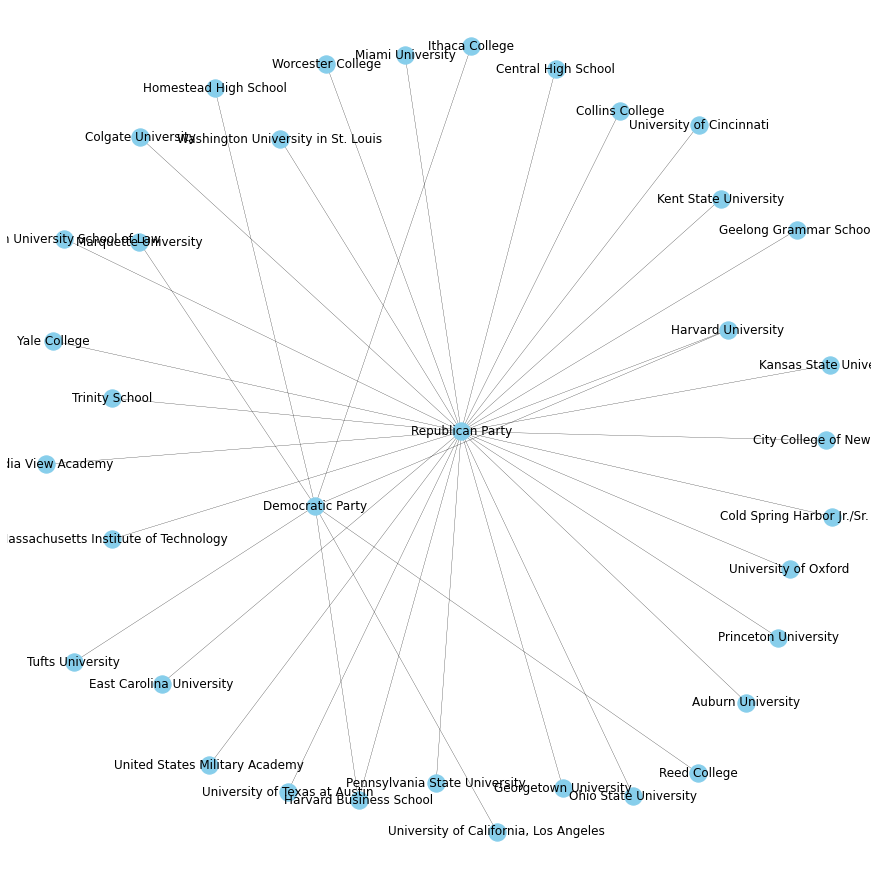

<Figure size 1440x432 with 0 Axes>

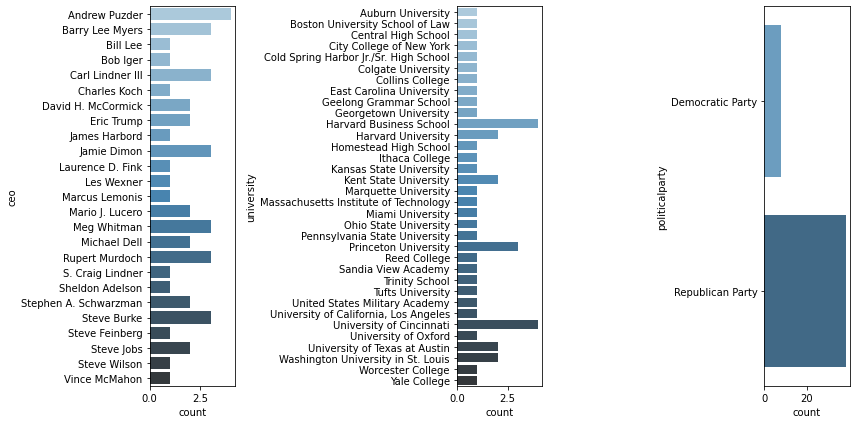

<Figure size 864x432 with 0 Axes>

In [ ]:
node_labels = ['ceo', 'university', 'politicalparty']
node_size_field = None
# field_filter = 'ind'
main(node_labels, node_size_field, data, query, field_filter=field_filter, filter=False)